In [12]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape
import numpy as np

In [2]:
# Load the shapefile containing the parcels
gdf = gpd.read_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")

In [ ]:
# Convert the CRS to WGS 84 (EPSG:4326)
# This is necessary for compatibility with other datasets and for visualization purposes.
# The original CRS of the shapefile is EPSG:31370, which is a Belgian Lambert 72 / Belgian Lambert 73 projection.
# Converting to EPSG:4326 allows for easier integration with web mapping services and other geospatial data.
gdf  = gdf.to_crs(epsg=4326)

In [ ]:

######### add numeric label 

Label_culture = pd.read_csv("REF_CULTURES_GROUPES.csv", sep=";")
Label_culture["Label"] = pd.to_numeric(Label_culture["Label"], errors="coerce").astype("Int64")
Label_culture["Label"] = Label_culture["Label"].fillna(0).astype(int)


gdf = gdf.merge(Label_culture[["Label","CODE_CULTURE"]], how="left", left_on="CODE_CULTU", right_on="CODE_CULTURE") #TODO check if this is right (CODE_CULTU)

gdf = gdf.rename(columns={"Label": "LABEL"})


In [9]:
gdf

NameError: name 'gdf' is not defined

In [5]:
import ee 
import geemap

/Users/placiermoise/Documents/remote sensing crop classification/.venv/lib/python3.12/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize()

In [7]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Draw a polygon on the map

polygone_hand_draw = Map.draw_features  

first_polygone = polygone_hand_draw[0] 

geom_hand_poly = first_polygone.geometry()

geom_hand_poly

Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")

In [ ]:
#  Convert the GEE geometry to GeoJSON format
# This is necessary to convert the GEE geometry into a format that can be used with shapely.  
geom_hand_poly_json = geom_hand_poly.getInfo()

#  Convert the GeoJSON to a shapely geometry
# This allows us to use the shapely library to manipulate and analyze the geometry.
hand_poly_shapely = shape(geom_hand_poly_json)


# Filter the GeoDataFrame to keep only the parcels that are within the drawn polygon
# This uses the shapely geometry to check if each parcel's geometry is within the drawn polygon.
# The 'within' method checks if the geometry of each parcel is completely contained within the polygon.
gdf_contained = gdf[gdf.geometry.within(hand_poly_shapely)]

# Convert the filtered GeoDataFrame to GeoJSON format
# This allows us to use the filtered data in other applications or for further processing.
Parcelle_within_hand_Poly_geojson = gdf_contained.__geo_interface__

# Convert the GeoDataFrame to an Earth Engine FeatureCollection
# This allows us to use the filtered data in Earth Engine for further analysis or visualization.
fc = geemap.geopandas_to_ee(gdf_contained, geodesic=False)
fc_geom = fc.geometry()

Map.addLayer(fc_geom, {}, "parcelles")

In [10]:
############ Import raster from the selected zone (hand poly )


Geometry_data_collect = geom_hand_poly

# Get the area value
area_m2 = geom_hand_poly.area(maxError=1)
print("Area (m²):", area_m2.getInfo())

Area (m²): 30411058.04554169


In [ ]:
from datetime import datetime, timedelta


start_date = '2023-01-01'
end_date = '2023-12-31'
bands = ['B2', 'B3', 'B4', 'B8']

# Generate half-monthly date ranges
def generate_half_month_ranges(start_date, end_date):
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        mid = current + timedelta(days=15)
        end_of_month = (current.replace(day=28) + timedelta(days=4)).replace(day=1)

        date_list.append((current.strftime('%Y-%m-%d'), min(mid, end).strftime('%Y-%m-%d')))
        date_list.append((min(mid, end).strftime('%Y-%m-%d'), min(end_of_month, end).strftime('%Y-%m-%d')))

        current = end_of_month

    return date_list

def generate_date_ranges(start_date, end_date, interval_days=15):
    """
    Génère des intervalles de dates de `interval_days` jours entre `start_date` et `end_date`.

    Args:
        start_date (str): Date de début au format 'YYYY-MM-DD'.
        end_date (str): Date de fin au format 'YYYY-MM-DD'.
        interval_days (int): Longueur de chaque intervalle en jours.

    Returns:
        List[Tuple[str, str]]: Liste de tuples (date_début, date_fin).
    """
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        next_date = current + timedelta(days=interval_days)
        date_list.append((
            current.strftime('%Y-%m-%d'),
            min(next_date, end).strftime('%Y-%m-%d')
        ))
        current = next_date

    return date_list

# Generate date ranges with a 30-day interval
#ranges = generate_half_month_ranges(start_date, end_date)
ranges = generate_date_ranges(start_date, end_date, interval_days=30)

In [ ]:
def mask_scl(img):
    scl = img.select('SCL')
    # Mask all pixels that are NOT in classes 4 to 7
    mask = (scl.eq(4)
           .Or(scl.eq(5))
           .Or(scl.eq(6))
           .Or(scl.eq(7)))
    return img.updateMask(mask)

def get_median_image(start, end, Geometry_data_collect):
    # Load the useful bands + SCL
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(Geometry_data_collect) \
        .filterDate(start, end) \
        .map(lambda img: img.clip(Geometry_data_collect)) \
        .map(mask_scl) \
        .select(bands)

    def compute_median():
        return collection.median() \
            .set('system:time_start', ee.Date(start).millis()) \
            .set('start_date', start) \
            .set('end_date', end) \
            .set('Number_of_aggreted_images', size)

    size = collection.size()
    median = ee.Algorithms.If(size.gt(0), compute_median(), None)
    return median

# Create a list of median images for each date range
median_images = [get_median_image(start, end, Geometry_data_collect) for start, end in ranges]

# Create a collection from the images
s2 = ee.ImageCollection(median_images)

# Example: print the size of the collection
print("Number of median images:", s2.size().getInfo())


Nombre d'images médianes : 12


In [ ]:
s2_list = s2.toList(s2.size())
n_images = s2.size().getInfo()
total_n_img = 0
for i in range(n_images):
    img = ee.Image(s2_list.get(i))
    props = img.toDictionary().getInfo()
    
    num_agg = props['Number_of_aggreted_images']
    total_n_img += num_agg
    print(f"Image {i} composed by {num_agg} images " )

print(total_n_img)

Image 0 composée de 6 images 
Image 1 composée de 6 images 
Image 2 composée de 6 images 
Image 3 composée de 6 images 
Image 4 composée de 6 images 
Image 5 composée de 6 images 
Image 6 composée de 7 images 
Image 7 composée de 6 images 
Image 8 composée de 6 images 
Image 9 composée de 6 images 
Image 10 composée de 6 images 
Image 11 composée de 6 images 
73


In [ ]:

# Define visualization parameters for Sentinel-2 imagery
# (Red: B4, Green: B3, Blue: B2)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 3000,
    'gamma': 1.3
}

# Center the map on the feature collection (fc)
Map.centerObject(fc, zoom=10)  

img_n = 6

s2_list = s2.toList(s2.size())
image = ee.Image(s2_list.get(img_n))
Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")
Map.addLayer(image, vis_params, f'Sentinel-2 RGB {img_n}')

Map

Map(bottom=765715.0, center=[43.64500738037024, 1.0472463503494793], controls=(WidgetControl(options=['positio…

In [ ]:
# Export the images to Google Drive as TIFF files
def export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels ): 
    # pixel overlap

    image_list = image_collection.toList(image_collection.size())
    n = image_collection.size().getInfo()
    
    for i in range(n):
        image = ee.Image(image_list.get(i)).clip(Geometry_data_collect)
        
        # Build a unique name, for example acquisition date
        date_str = image.date().format('YYYYMMdd').getInfo()
        task = ee.batch.Export.image.toDrive(
            image=image,
            description= "export",
            folder=export_folder,
            fileNamePrefix=f'sentinel2_{date_str}',
            region=Geometry_data_collect,
            scale=10,
            crs='EPSG:4326',
            maxPixels=export_maxPixels
        )
        task.start()
        print(f"Export started for image {i+1}/{n}, date : {date_str}")

In [ ]:
# export to TIFF format
image_collection = s2
export_folder = 'GEE_export_6_median'
export_maxPixels = 1e10


export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels )

Export lancé pour l’image 1/12, date : 20230101
Export lancé pour l’image 2/12, date : 20230131
Export lancé pour l’image 3/12, date : 20230302
Export lancé pour l’image 4/12, date : 20230401
Export lancé pour l’image 5/12, date : 20230501
Export lancé pour l’image 6/12, date : 20230531
Export lancé pour l’image 7/12, date : 20230630
Export lancé pour l’image 8/12, date : 20230730
Export lancé pour l’image 9/12, date : 20230829
Export lancé pour l’image 10/12, date : 20230928
Export lancé pour l’image 11/12, date : 20231028
Export lancé pour l’image 12/12, date : 20231127


In [ ]:
# Pixel Count
s2_first_img = ee.Image(s2.first())  # or .mosaic() if you want to avoid the clouds

# Option 1 : pixelCount
pixel_count = s2_first_img.select('B2').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=Geometry_data_collect,
    scale=10,
    maxPixels=1e9
)

print("Number of valid pixels in B2 :", pixel_count.getInfo()['B2'])

Nombre de pixels valides dans B2 : 141726


In [37]:
import os as os
import tqdm 
import rasterio as rasterio
base_dir = "../data/Tif"

Nombre de NaN dans l'image : 14864


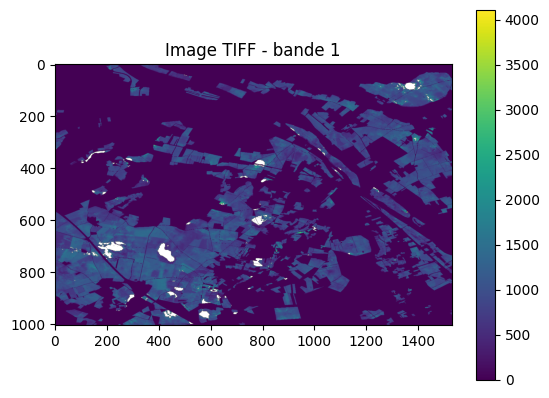

In [53]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open('../data/Tif/zone2/sentinel2_20231028_masked.tif') as src:
    img = src.read(2) 
    
nan_count = np.isnan(img).sum()  # compte les NaN dans img
print(f"Nombre de NaN dans l'image : {nan_count}")

plt.imshow(img, cmap='viridis')  # or 'viridis', 'jet', etc.
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()

#src.close()

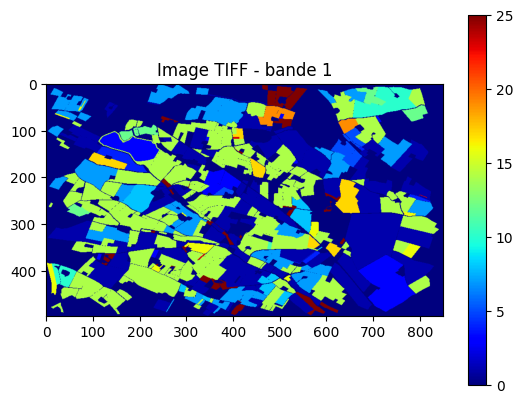

In [ ]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd

# Load annotation polygons (with a "class_id" field)
gdf_to_rasterize = gdf_contained

# Load a reference image to retrieve the size, transform, and projection
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/sentinel2_2.tif') as src:
    meta = src.meta.copy()

# Rasterize 
shapes = ((geom, value) for geom, value in zip(gdf_to_rasterize.geometry, gdf_to_rasterize['LABEL']))
label_raster = rasterize(
    shapes,
    out_shape=(meta['height'], meta['width']),
    transform=meta['transform'],
    fill=0,  # background label
    dtype=rasterio.uint8
)

# Sauvegarder le raster labelisé
meta.update({'count': 1, 'dtype': rasterio.uint8})
with rasterio.open('labels_raster.tif', 'w', **meta) as dst:
    dst.write(label_raster, 1)

with rasterio.open('labels_raster.tif') as src:
    img = src.read(1)   # read the first band

plt.imshow(img, cmap='jet')  
plt.colorbar()
plt.title('Image TIFF - band 1')
plt.show()

In [ ]:

with rasterio.open('labels_raster.tif') as src:
    img_reference = src.read(1)  # read the first band

img_reference

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(497, 850), dtype=uint8)

In [ ]:
import os
import argparse
import numpy as np
import h5py
import rasterio
from rasterio.windows import Window
from tqdm import tqdm


tif_dir = '/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/'

def mask_no_label(tif_dir):
    with rasterio.open('labels_raster.tif') as src:
        img_reference = src.read(1) # read the first band
    # Get all tif files sorted by date
    tif_files = sorted([os.path.join(tif_dir, f) for f in os.listdir(tif_dir) if f.endswith('.tif')])

    for tif_path in tqdm(tif_files, desc="mask for TIFF images"):
        with rasterio.open(tif_path) as src:
            data = src.read()  # Shape: (bands, height, width)
            profile = src.profile
            # Mask: True where the reference value is 0
            mask = (img_reference == 0)
            # Apply the mask to all bands
            data[:, mask] = 0
        # Saving to a new file
        base_name = os.path.basename(tif_path).replace('.tif', '_masked.tif')
        output_path = os.path.join('data/Tif', base_name)

       # Writing the masked file
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)

mask_no_label(tif_dir)

mask des TIF: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


In [42]:
import h5py
import os

# Path to your HDF5 file
h5_path = '../data/dataset.h5'

# File size on disk (in MB)
file_size_mb = os.path.getsize(h5_path) / (1024 * 1024)
print(f"File size: {file_size_mb:.2f} MB")

# Open and inspect the content
with h5py.File(h5_path, 'r') as f:
    print("\nKeys found in the HDF5 file:")
    for key in f.keys():
        data = f[key]
        print(f"- {key} : shape={data.shape}, dtype={data.dtype}")

File size: 497.34 MB

Keys found in the HDF5 file:
- ID_Parcelles : shape=(14836, 24, 24), dtype=float32
- coords : shape=(14836, 2), dtype=float64
- data : shape=(14836, 12, 4, 24, 24), dtype=float32
- dates : shape=(12,), dtype=object
- labels : shape=(14836, 24, 24), dtype=float32


In [46]:
with h5py.File(h5_path, 'r') as f:
    labels = f["labels"][:]
    data =  f["data"][:] 
    coords = f["coords"][:] 
    print(f["data"][1])

    uniques = np.unique(labels)
    nan = np.isnan(data).sum()
    labnan = np.isnan(labels).sum()
    datenan = np.isnan(coords).sum()
    print(uniques)
    print("nombre data nan", nan)
    print("nombre de label nan", labnan)
    print("nombre de date nan", datenan)

    print("Min label:", labels.min())
    print("Max label:", labels.max())
    print(type(labels[0][0]))

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
 